In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import tensorflow as tf 
from sklearn.model_selection import train_test_split

In [3]:
DATA_DIR_1 = "/kaggle/input/nih-data/images_001/images"
DATA_DIR_2 = "/kaggle/input/nih-data/images_002/images"
CSV_PATH   = "/kaggle/input/nih-data/Data_Entry_2017.csv"

In [26]:
images_1 = glob(os.path.join(DATA_DIR_1, "*.png"))
images_2 = glob(os.path.join(DATA_DIR_2, "*.png"))
all_images = images_1 + images_2
print(f"Total images: {len(all_images)}")

IMG_DIR = "/kaggle/working/all_images"

Total images: 14999


In [34]:
df = pd.read_csv("/kaggle/input/nih-data/Data_Entry_2017.csv")

tabular_cols = ['Patient Age','Patient Gender','View Position']
label_cols = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
              'Emphysema','Fibrosis','Hernia','Infiltration','Mass','No Finding',
              'Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']

In [35]:
if 'Finding Labels' in df.columns:
    df_labels = df['Finding Labels'].str.get_dummies(sep='|')
    label_cols = df_labels.columns.tolist()
    df = pd.concat([df, df_labels], axis=1)
else:
    label_cols = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
                  'Emphysema','Fibrosis','Hernia','Infiltration','Mass','No Finding',
                  'Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']


tabular_cols = ['Patient Age','Patient Gender','View Position']

df['Patient Gender'] = df['Patient Gender'].replace({'M':1,'F':0}).astype(float)
df['View Position'] = df['View Position'].replace({'PA':1,'AP':0}).astype(float)

images_1 = glob(os.path.join(DATA_DIR_1, "*.png"))
images_2 = glob(os.path.join(DATA_DIR_2, "*.png"))
all_images = images_1 + images_2
print(f"Total images found: {len(all_images)}")

path_dict = {os.path.basename(p): p for p in all_images}

df['img_path'] = df['Image Index'].map(path_dict)
irrelevant_cols = [
    'Image Index',       # used only for mapping img_path
    'Finding Labels',    # replaced by multi-hot columns
    'Follow-up #',       # not predictive
    'Patient ID',        # identifier
    'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x','y]','Unnamed: 11'
]

# Drop columns that exist in df
df = df.drop(columns=[col for col in irrelevant_cols if col in df.columns])


# Drop rows with missing images
df = df.dropna(subset=['img_path'])

train_df, tmp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df  = train_test_split(tmp_df, test_size=0.5, random_state=42)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Total images found: 14999
Train samples: 11999
Validation samples: 1500
Test samples: 1500


/tmp/ipykernel_36/109226015.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Patient Gender'] = df['Patient Gender'].replace({'M':1,'F':0}).astype(float)
/tmp/ipykernel_36/109226015.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['View Position'] = df['View Position'].replace({'PA':1,'AP':0}).astype(float)


In [31]:
train_df

,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
109402,33,1.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
83153,59,1.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12902,49,0.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
106281,57,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
52472,47,1.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,71,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
110268,69,1.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
103694,32,1.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
860,59,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [36]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(df_input, batch=True, augment=False):
    img_paths = df_input['img_path'].values
    tab = df_input[tabular_cols].values.astype(np.float32)
    labels = df_input[label_cols].values.astype(np.float32)
    
    ds = tf.data.Dataset.from_tensor_slices((img_paths, tab, labels))
    
    def _parse(path, tabrow, lab):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return ({"image_input": img, "tab_input": tabrow}, lab)
    
    ds = ds.map(_parse, num_parallel_calls=AUTOTUNE)
    
    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.05),
        ])
        ds = ds.map(lambda x,y: ({"image_input": aug(x['image_input'], training=True),
                                  "tab_input": x['tab_input']}, y),
                    num_parallel_calls=AUTOTUNE)
    
    if batch:
        ds = ds.shuffle(2000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, augment=True)
val_ds   = make_dataset(val_df, augment=False)
test_ds  = make_dataset(test_df, augment=False)

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

convnext_model = tf.keras.applications.ConvNeXtTiny(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

image_input = Input(shape=(224, 224, 3), name="image_input")

for layer in convnext_model.layers[-10:]: 
    layer.trainable = True

x = convnext_model(image_input)  

x = layers.GlobalAveragePooling2D()(x)

tab_input = Input(shape=(3,), name="tab_input")  


combined = layers.Concatenate()([x, tab_input])

combined = layers.Dense(256, activation="relu")(combined)
combined = layers.Dropout(0.5)(combined)

output = layers.Dense(15, activation="sigmoid")(combined)

model = models.Model(inputs=[image_input, tab_input], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)]
)

model.summary()




111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny       │ (None, 7, 7, 768) │ 27,820,128 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ convnext_tiny[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 771)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ tab_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    197,632 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │      3,855 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,021,615 (106.89 MB)

 Trainable params: 28,021,615 (106.89 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)]
)


Epoch 1/50


I0000 00:00:1758948403.868081      99 service.cc:148] XLA service 0x7e8060014b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758948403.868994      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758948403.869014      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758948407.774021      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1758948410.873072      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758948411.008893      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758948413.215694      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.2725 - auc: 0.4970 - loss: 0.5953

E0000 00:00:1758948781.409864     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758948781.545609     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758948783.742725     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758948783.877004     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.2728 - auc: 0.4970 - loss: 0.5947

E0000 00:00:1758948825.365158     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758948825.500775     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


375/375 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.2731 - auc: 0.4970 - loss: 0.5941 - val_accuracy: 0.5833 - val_auc: 0.5031 - val_loss: 0.2035
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 371s 945ms/step - accuracy: 0.4876 - auc: 0.5060 - loss: 0.2572 - val_accuracy: 0.5833 - val_auc: 0.5328 - val_loss: 0.2005
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 371s 945ms/step - accuracy: 0.5140 - auc: 0.5039 - loss: 0.2477 - val_accuracy: 0.5833 - val_auc: 0.5094 - val_loss: 0.2004
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 371s 944ms/step - accuracy: 0.5196 - auc: 0.4962 - loss: 0.2434 - val_accuracy: 0.5833 - val_auc: 0.5336 - val_loss: 0.1991
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 369s 940ms/step - accuracy: 0.5273 - auc: 0.5043 - loss: 0.2417 - val_accuracy: 0.5833 - val_auc: 0.5207 - val_loss: 0.1993
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 371s 944ms/step - accuracy: 0.5375 - auc: 0.5034 - loss: 0.2377 - val_accuracy: 0.5833 - val_auc: 0.5355 - val_loss: 0.1981
Epoch 7/50
375/375 ━━━━━━━━━━━

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, multilabel_confusion_matrix, RocCurveDisplay

In [12]:
y_pred_prob = model.predict(test_ds, verbose=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = (y_pred_prob >= 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step


In [14]:
report = classification_report(y_true, y_pred, target_names=df.columns[4:], zero_division=0)
print("Classification Report:\n")
print(report)

Classification Report:

                    precision    recall  f1-score   support

      Cardiomegaly       0.14      0.01      0.01       131
     Consolidation       0.00      0.00      0.00        31
             Edema       0.00      0.00      0.00        55
          Effusion       0.00      0.00      0.00        24
         Emphysema       0.03      0.01      0.01       132
          Fibrosis       0.00      0.00      0.00        28
            Hernia       0.00      0.00      0.00        45
      Infiltration       0.00      0.00      0.00         3
              Mass       0.33      0.01      0.02       242
        No Finding       0.00      0.00      0.00        50
            Nodule       0.59      0.64      0.61       862
Pleural_Thickening       0.00      0.00      0.00        79
         Pneumonia       0.00      0.00      0.00        39
      Pneumothorax       0.00      0.00      0.00        19
          img_path       0.00      0.00      0.00        65

         micro

In [16]:
auc_per_label = {}
for i, label in enumerate(df.columns[4:]):
    try:
        auc_score = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
    except ValueError:
        auc_score = np.nan
    auc_per_label[label] = auc_score

auc_table = pd.DataFrame.from_dict(auc_per_label, orient='index', columns=['AUC'])
print("\nAUC per label:")
print(auc_table)


AUC per label:
                         AUC
Cardiomegaly        0.545670
Consolidation       0.532840
Edema               0.501151
Effusion            0.511828
Emphysema           0.483475
Fibrosis            0.486267
Hernia              0.543093
Infiltration        0.404587
Mass                0.508038
No Finding          0.451945
Nodule              0.524409
Pleural_Thickening  0.547778
Pneumonia           0.559996
Pneumothorax        0.537830
img_path            0.517813


In [17]:
macro_auc = roc_auc_score(y_true, y_pred_prob, average='macro')
micro_auc = roc_auc_score(y_true, y_pred_prob, average='micro')
print(f"\nMacro AUC: {macro_auc:.4f}")
print(f"Micro AUC: {micro_auc:.4f}")


Macro AUC: 0.5104
Micro AUC: 0.8069


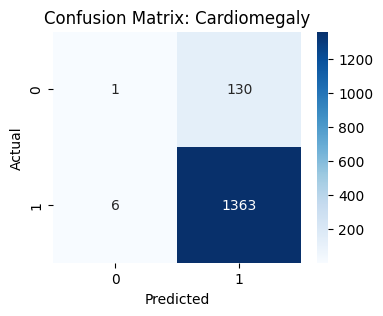

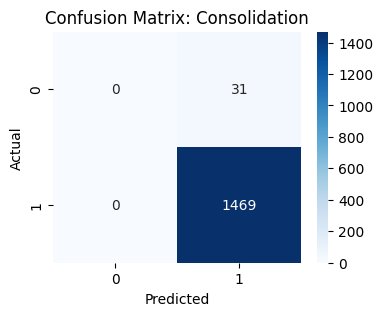

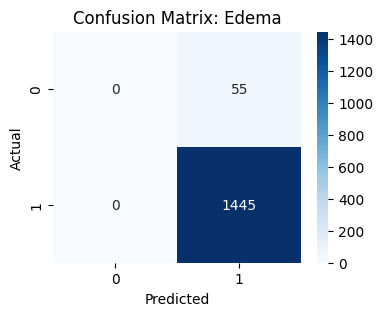

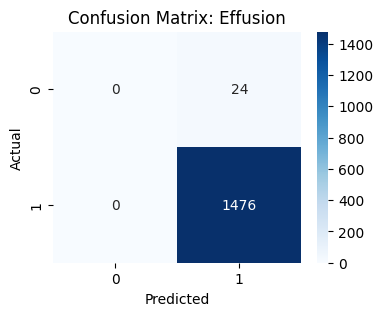

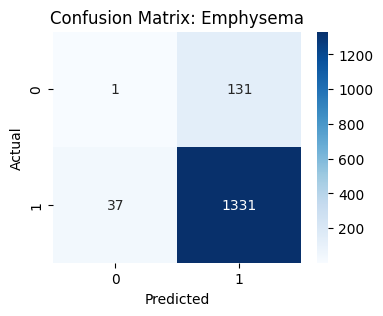

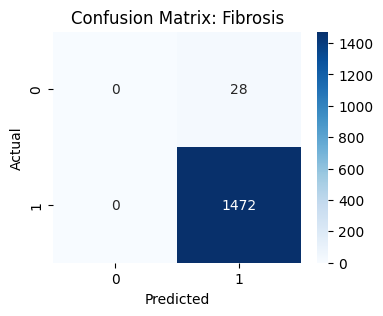

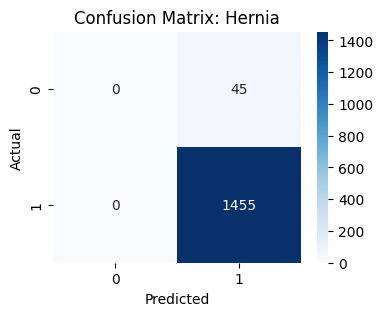

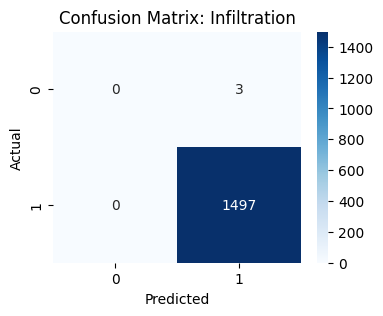

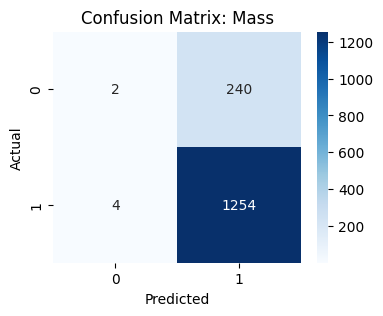

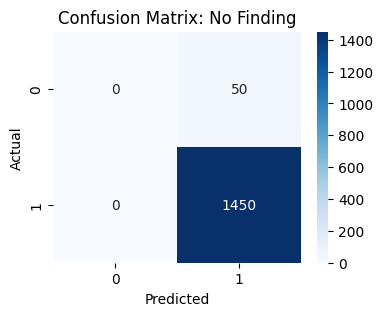

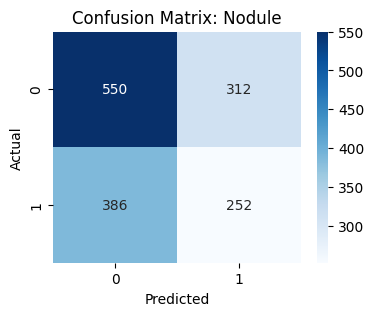

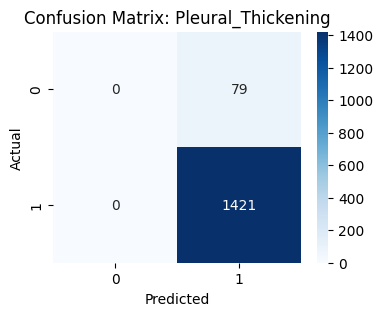

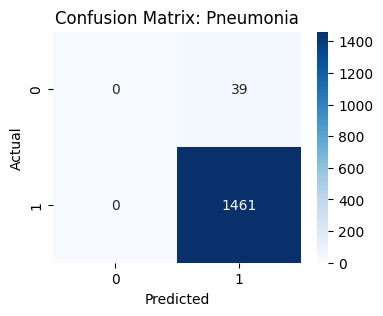

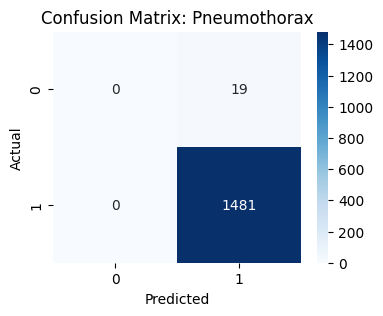

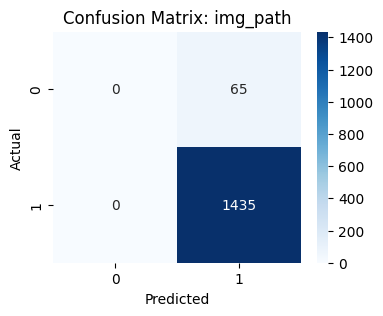

In [19]:
mcm = multilabel_confusion_matrix(y_true, y_pred)

for i, label in enumerate(df.columns[4:]):
    tn, fp, fn, tp = mcm[i].ravel()
    plt.figure(figsize=(4,3))
    sns.heatmap([[tp, fn],[fp, tn]], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

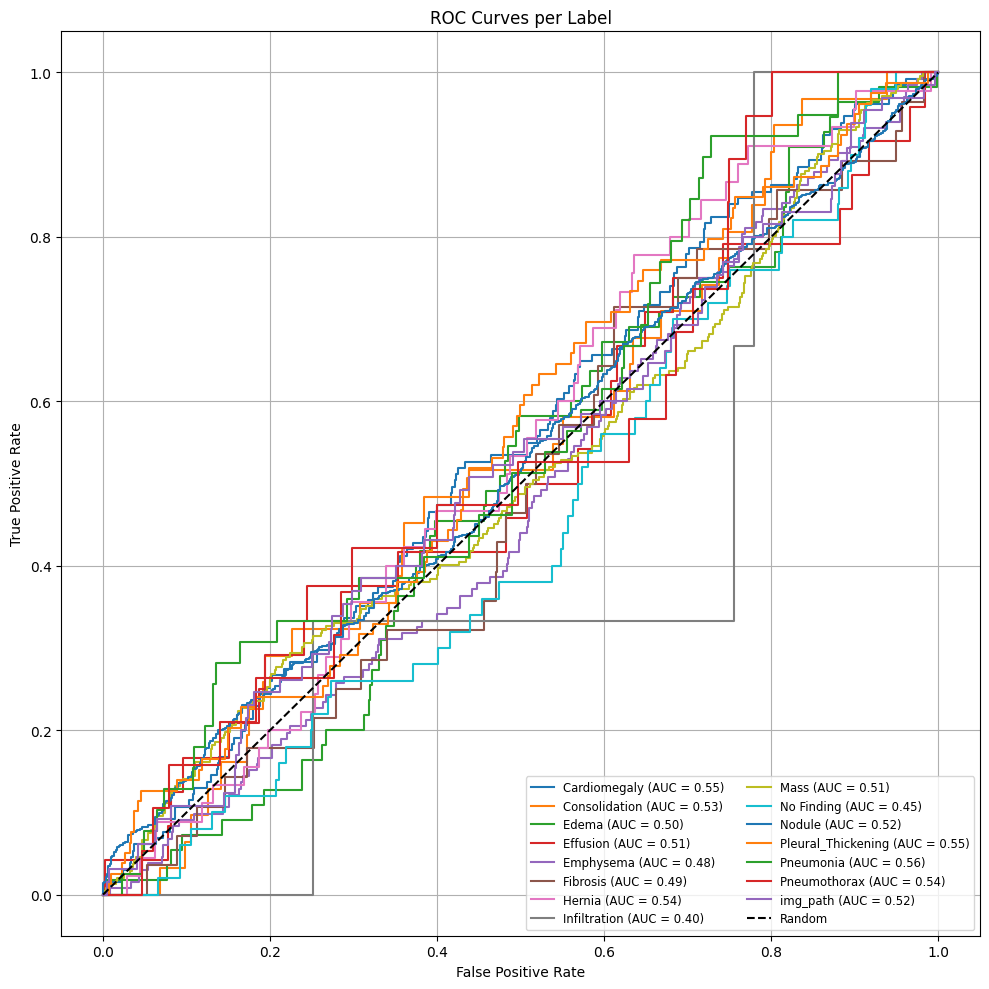

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np

# Assuming y_true and y_pred_prob are numpy arrays of shape (n_samples, 15)
# y_true = ground truth (binary indicators), y_pred_prob = predicted probabilities
# df.columns[4:] should be your class labels (15 labels)

plt.figure(figsize=(10, 10))
ax = plt.gca()

for i, label in enumerate(df.columns[4:]):
    try:
        RocCurveDisplay.from_predictions(
            y_true[:, i], 
            y_pred_prob[:, i],
            name=label,
            ax=ax
        )
    except ValueError:
        print(f"Skipped {label} due to ValueError (e.g., only one class present).")
        continue

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curves per Label')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc='lower right', fontsize='small', ncol=2)  # Adjust as needed
plt.tight_layout()
plt.show()
